In [7]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [8]:
reader = csv.reader(open("hepatitis_2_csv.csv", "r"))
x = list(reader)
res = np.array(x).astype("float")

In [339]:
training_class_name=res[0:568,19:20];
training_data=res[0:568,0:19];
training_data=np.matrix(training_data)
training_data=training_data.transpose()
training_class_name=np.matrix(training_class_name)
training_class_name=training_class_name.transpose()

In [531]:
class Net:
    def __init__(self):
        self.weights=[];
        self.bias=[];
        self.status=[];
        self.a=[];
        self.z=[];
        self.da=[];
        self.dz=[];
        self.dw=[];
        self.db=[];
        self.cost=[];
        self.trainingOutput=[];
        self.correctOutput=[];
        
    def model(self,layers):
        self.layers=layers
        self.status.append("Model archetecture recieved")
        self.createBrain()
        self.status.append("Model archetecture created")
        return self.layers
    
    def createBrain(self):
        inputshape = self.layers[0].getshape()
        self.weights.append(0.01*np.random.rand(self.layers[1].getparams()["noOfUnits"],inputshape[0]))
        self.bias.append(np.ones([self.layers[1].getparams()["noOfUnits"],inputshape[1]]))
        print("layer 1 has bias shape as {} and weights shape as {}".format(self.bias[0].shape,self.weights[0].shape))
        for i in range(2,len(self.layers)):
            lowerlimit=self.layers[i].getparams()["noOfUnits"]
            upperlimit=self.layers[i-1].getparams()["noOfUnits"]
            self.weights.append(0.01*np.random.rand(lowerlimit,upperlimit))
            self.bias.append(np.ones([lowerlimit,inputshape[1]]))
            print("layer {} has bias shape as {} and weights shape as {}".format(i,self.bias[i-1].shape,self.weights[i-1].shape))
    
    def train(self,epochs,traindata,trainoutcome,LearningRate):
        self.epochs=np.asmatrix(np.arange(0,epochs,1))
        for i in range(0,epochs):
            val = self.forewardProp(traindata,trainoutcome)
            self.trainingOutput.append(val)
            self.correctOutput.append(trainoutcome)
            self.status.append("Foreward Propogation for epoch {} is done".format(i))
            self.backwardProp(trainoutcome,LearningRate)
            self.status.append("Backward Propogation for epoch {} is done".format(i))
            
        self.trainingOutput=np.asarray(self.trainingOutput)
        self.correctOutput=np.asarray(self.correctOutput)
    
    def forewardProp(self,traindata,trainoutcome):
        self.a.append(traindata)
        self.weights=np.asarray(self.weights)
        self.bias=np.asarray(self.bias)
        z=np.dot(self.weights[0],traindata)+self.bias[0]
        self.z.append(z)
        
        if(self.layers[1].getparams()["activation"]=="sigmoid"):
            self.a.append(self.sigmoid(z))
        elif(self.layers[1].getparams()["activation"]=="tanh"):
            self.a.append(self.tanh(z))
        elif(self.layers[1].getparams()["activation"]=="relu"):
            self.a.append(self.relu(z))
            
       # cost=self.costfunc(traindata,trainoutcome,self.a[0])
       # self.cost.append(cost)
        
        for i in range(2,len(self.layers)):
            z=np.dot(self.weights[i-1],self.a[i-1])+self.bias[i-1]
            self.z.append(z)
            if(self.layers[1].getparams()["activation"]=="sigmoid"):
                self.a.append(self.sigmoid(z))
            elif(self.layers[1].getparams()["activation"]=="tanh"):
                self.a.append(self.tanh(z))
            elif(self.layers[1].getparams()["activation"]=="relu"):
                self.a.append(self.relu(z))
        return self.a[len(self.layers)-1]
        #    cost=self.costfunc(traindata,trainoutcome,self.a[i-1])
        #    self.cost.append(cost)
        #    print(cost)
     
    #def costfunc(self,traindata,trainoutcome,res):
     #   A1=np.multiply(trainoutcome,np.log(res))
     #   A2=np.multiply((1-outputmatrix),np.log((1-res)))
     #   cost=A1+A2
     #   cost=(-1/len(traindata))*cost
     #   cost=np.sum(cost)
     #   return cost
    
    def backwardProp(self,trainoutcome,learningRate):
        self.da.append( (-trainoutcome/self.a[len(self.layers)-1])+( (1-trainoutcome)/(1-self.a[len(self.layers)-1])) );
        for i in range(0,len(self.layers)-1):
            sigmoidprime=np.multiply((self.sigmoid( self.z[len(self.layers)-2-i] ) ),( 1-(self.sigmoid(self.z[len(self.layers)-2-i])) ))
            dz = np.multiply(self.da[i],sigmoidprime)
            self.dz.append(dz)
            dw = (1/len(trainoutcome))*(dz*self.a[len(self.layers)-2-i].transpose())
            self.dw.append(dw)
            db=(1/len(trainoutcome))*np.sum(dz,axis=1)
            self.db.append(db)
            daminusone=(self.weights[len(self.layers)-2-i].transpose())*dz
            self.da.append(daminusone)
            # Updating weights
            self.weights[len(self.layers)-2-i] = self.weights[len(self.layers)-2-i] - learningRate*self.dw[i]
            self.bias[len(self.layers)-2-i] = self.bias[len(self.layers)-2-i] - learningRate*self.db[i]
            
    def results(self):
        #print(self.correctOutput.shape,self.trainingOutput.shape)
        ls=self.correctOutput - self.trainingOutput
        loss=np.sum(ls,axis=1)
        loss=loss/len(loss)
        ac=np.sum(self.correctOutput==self.trainingOutput,axis=1)
        accuracy=ac/len(self.correctOutput)
        plt.subplot(1,2,1)
        plt.plot(self.epochs.T,accuracy)
        plt.title("Training Accuracy")
        plt.xlabel("epochs")
        plt.ylabel("Accuracy")
        plt.subplot(1,2,2)
        plt.plot(self.epochs.T,loss)
        plt.title("Training Loss")
        plt.xlabel("epochs")
        plt.ylabel("Loss")
        #print("Accuracy : {}".format(accuracy[len(accuracy)-1]))
        #print("loss : {}".format(loss[len(loss)-1]))
    
    def sigmoid(self,X):
        return 1/(1+np.exp(-X));

    def tanh(self,X):
        return np.tanh(X);

    def relu(self,X):
        return np.maximum(0, X);

    def getActivation(self):
        # plot the activation function using matplotlib library
        cur_axes = plt.gca()
        # to remove the x axis
        cur_axes.axes.get_xaxis().set_visible(False)
        rangex=np.linspace(-10, 10, 100)

        if(self.activation=="sigmoid"):
            plt.plot(rangex,self.sigmoid(rangex))
        elif(self.activation=="tanh"):
            plt.plot(rangex,self.tanh(rangex))
        elif(self.activation=="relu"):
            plt.plot(rangex,self.relu(rangex))
            plt.title("activation function = "+self.activation)
        
    class Layers:
        
        class InputLayer:
            
            def __init__(self,shape):
                self.shape=shape
                
            def getshape(self):
                return np.asarray(self.shape).transpose()
        
        class DenseLayer:
            
            def __init__(self,noOfUnits,activation):
                self.params={"activation":activation,"shape":(noOfUnits,1),"noOfUnits":noOfUnits}
                
            def getparams(self):
                return self.params

In [532]:
my_brain = Net()
l1=Net.Layers.InputLayer(training_data.shape)
l2=Net.Layers.DenseLayer(15 , activation="sigmoid")
l3=Net.Layers.DenseLayer(10 , activation="sigmoid")
l4=Net.Layers.DenseLayer(5 , activation="sigmoid")
l5=Net.Layers.DenseLayer(4 , activation="sigmoid")
l6=Net.Layers.DenseLayer(1 , activation="sigmoid")
archetecture = my_brain.model(
    layers=[l1,l2,l3,l4,l5,l6]
)

layer 1 has bias shape as (15, 568) and weights shape as (15, 19)
layer 2 has bias shape as (10, 568) and weights shape as (10, 15)
layer 3 has bias shape as (5, 568) and weights shape as (5, 10)
layer 4 has bias shape as (4, 568) and weights shape as (4, 5)
layer 5 has bias shape as (1, 568) and weights shape as (1, 4)


In [533]:
my_brain.train(10,training_data,training_class_name,0.01)

(10, 1, 568) (10, 1, 568)


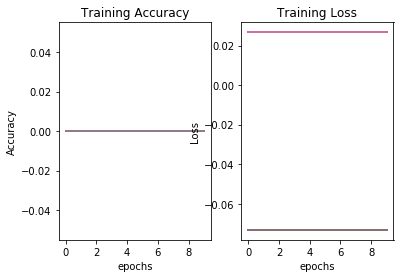

In [534]:
results=my_brain.results()